# Description

* Trimming the FullCyc 12C-Con HR-SIP dataset to match the reference genome pool size

# Setting variables

In [1]:
workDir = '/home/nick/notebook/SIPSim/dev/fullCyc_trim/'

physeqDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7/phyloseq/'
physeq_bulkCore = 'bulk-core'
physeq_SIP_core = 'SIP-core_unk'

ampFrag_KDE_info = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags_kde_info.txt'

# Init

In [2]:
import os
import sys
%load_ext rpy2.ipython
%load_ext pushnote

In [3]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)
library(vegan)
library(robCompositions)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘gridExtra’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:dplyr’:

    combine


  res 

In [4]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
%cd $workDir

/home/nick/notebook/SIPSim/dev/fullCyc_trim


In [5]:
%%R
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

cat('Min BD:', min_BD, '\n')
cat('Max BD:', max_BD, '\n')

Min BD: 1.67323 
Max BD: 1.7744 


# Checking how many taxa actually amplify for the in-silco PCR 

In [6]:
%%R -i ampFrag_KDE_info 

ntaxa = read.delim(ampFrag_KDE_info, sep='\t') %>%
    filter(! is.nan(KDE_ID)) %>%
    distinct(taxon_ID) %>% nrow

cat('Number of taxa that have amplicon-fragments: ', ntaxa, '\n')

Number of taxa that have amplicon-fragments:  1102 


## Parsing out amplicon fragments of just the taxa that amplified

In [8]:
%%R -i workDir

F = file.path(workDir, 'ampFrags_kde_amplified.txt')

taxa = read.delim(ampFrag_KDE_info, sep='\t') %>%
    filter(! is.nan(KDE_ID)) %>% 
    select(taxon_ID) %>%
    distinct(taxon_ID) %>%
    rename('genomeID' = taxon_ID)
              
write.table(taxa, F, quote=FALSE, row.names=FALSE, col.names=TRUE)
cat('File written:', F, '\n')

File written: /home/nick/notebook/SIPSim/dev/fullCyc_trim//ampFrags_kde_amplified.txt 


# Loading data

## Pre-fractionation samples

In [17]:
%%R -i physeqDir -i physeq_bulkCore

physeq.file = file.path(physeqDir, physeq_bulkCore)
physeq.bulk = readRDS(physeq.file)

physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk = prune_samples(physeq.bulk.m$Exp_type == 'microcosm_bulk' &
                            physeq.bulk.m$Substrate == '12C-Con', physeq.bulk)

physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4950 taxa and 6 samples ]
sample_data() Sample Data:       [ 6 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 4950 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4950 tips and 4949 internal nodes ]


## Fraction samples

In [18]:
%%R -i physeqDir -i physeq_SIP_core 

# bulk core samples
F = file.path(physeqDir, physeq_SIP_core)
physeq.SIP.core = readRDS(F) 
physeq.SIP.core.m = physeq.SIP.core %>% sample_data

physeq.SIP.core = prune_samples(physeq.SIP.core.m$Substrate == '12C-Con', 
                                physeq.SIP.core) %>%
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.SIP.core.m = physeq.SIP.core %>% sample_data        

physeq.SIP.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9974 taxa and 142 samples ]
sample_data() Sample Data:       [ 142 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 9974 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9974 tips and 9973 internal nodes ]


# Selecting taxa from pre-frac sample

* Just N-most abundant taxa
  * N = number of genomes in simulations

In [19]:
%%R
df.bulk.otu = physeq.bulk %>% 
    otu_table %>% 
    as.data.frame 

df.bulk.otu$OTU = rownames(df.bulk.otu)

df.bulk.otu = df.bulk.otu %>%
    gather(sample, count, ends_with('_bulk')) %>%
    group_by(sample) %>%
    mutate(rank_abund = row_number(-count)) %>%
    ungroup() %>%
    filter(rank_abund <= ntaxa) %>%
    arrange(rank_abund) 
    
df.bulk.otu %>% nrow %>% print
df.bulk.otu$OTU %>% unique %>% length %>% print
df.bulk.otu %>% head(n=3)

[1] 6612
[1] 2611
Source: local data frame [3 x 4]

        OTU              sample count rank_abund
      (chr)               (chr) (dbl)      (int)
1     OTU.1  12C-Con.D3.R3_bulk   976          1
2     OTU.1  12C-Con.D6.R2_bulk   779          1
3 OTU.14142 12C-Con.D30.R1_bulk   234          1


In [20]:
%%R
# filtering taxa from fraction samples & performing total-sum scaling (closure operation)

bulk.samples = df.bulk.otu$sample %>% unique

physeq.SIP.l = list()
for (bs in bulk.samples){
    df.otus = df.bulk.otu %>%
        filter(sample == bs)
    day = gsub('.+\\.D([0-9]+)\\.R.+', '\\1', bs) %>% as.numeric
    physeq.SIP.l[[bs]] = prune_samples(physeq.SIP.core.m$Day == day, physeq.SIP.core)
    physeq.SIP.l[[bs]] = prune_taxa(df.otus$OTU,  physeq.SIP.l[[bs]]) %>%
                        transform_sample_counts(function(x) x/sum(x))
                
}

physeq.SIP.l

$`12C-Con.D3.R3_bulk`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1097 taxa and 23 samples ]
sample_data() Sample Data:       [ 23 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 1097 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1097 tips and 1096 internal nodes ]

$`12C-Con.D6.R2_bulk`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1096 taxa and 23 samples ]
sample_data() Sample Data:       [ 23 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 1096 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1096 tips and 1095 internal nodes ]

$`12C-Con.D30.R1_bulk`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1100 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 1100 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1100 tips and 1099 internal nodes 

### Saving phyloseq object

In [12]:
%%R -i workDir
outFile = 'SIP-core_unk_trm'
outFile = file.path(workDir, outFile)

saveRDS(physeq.SIP.l, outFile)
cat('File written:', outFile, '\n')

File written: /home/nick/notebook/SIPSim/dev/fullCyc_trim//SIP-core_unk_trm 


### Making a pruned pre-fractionation phyloseq file

In [21]:
%%R
# filtering taxa from fraction samples & performing total-sum scaling (closure operation)

bulk.samples = df.bulk.otu$sample %>% unique

physeq.bulk.l = list()
for (bs in bulk.samples){
    df.otus = df.bulk.otu %>%
        filter(sample == bs)
    day = gsub('.+\\.D([0-9]+)\\.R.+', '\\1', bs) %>% as.numeric
    physeq.bulk.l[[bs]] = prune_samples(physeq.bulk.m$Day == day, physeq.bulk)
    physeq.bulk.l[[bs]] = prune_taxa(df.otus$OTU,  physeq.bulk.l[[bs]]) %>%
                        transform_sample_counts(function(x) x/sum(x))
                
}

physeq.bulk.l

$`12C-Con.D3.R3_bulk`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1102 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 1102 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1102 tips and 1101 internal nodes ]

$`12C-Con.D6.R2_bulk`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1102 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 1102 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1102 tips and 1101 internal nodes ]

$`12C-Con.D30.R1_bulk`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1102 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 1102 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1102 tips and 1101 internal nodes ]

$`1

In [14]:
%%R -i workDir
outFile = 'bulk-core_trm'
outFile = file.path(workDir, outFile)

saveRDS(physeq.bulk.l, outFile)
cat('File written:', outFile, '\n')

File written: /home/nick/notebook/SIPSim/dev/fullCyc_trim//bulk-core_trm 


# Converting to long OTU table (reload)

* Just abundant OTUs in bulk soil samples (above rank-order cutoff) will have an abundance value; others get abundance of 0

## SIP data

In [22]:
%%R -i workDir
F = file.path(workDir, 'SIP-core_unk_trm')
physeq.SIP.l = readRDS(F)
physeq.SIP.l %>% names

[1] "12C-Con.D3.R3_bulk"  "12C-Con.D6.R2_bulk"  "12C-Con.D30.R1_bulk"
[4] "12C-Con.D1.R2_bulk"  "12C-Con.D48.R3_bulk" "12C-Con.D14.R1_bulk"


In [23]:
%%R

otu2df = function(x){
    x %>% otu_table %>% as.data.frame
    }

otu.l = lapply(physeq.SIP.l, otu2df) 

samps = names(otu.l)
df.SIP.otu = otu.l[[samps[1]]]
df.SIP.otu$OTU = rownames(df.SIP.otu)
for (x in samps[2:length(samps)]){
    y = otu.l[[x]] 
    y$OTU = rownames(y)
    df.SIP.otu = left_join(df.SIP.otu, y, c('OTU' = 'OTU'))
}

otu.l = NULL
df.SIP.otu[is.na(df.SIP.otu)] = 0
df.SIP.otu[1:5, 1:5]

  12C-Con.D3.R3_F20 12C-Con.D3.R3_F18 12C-Con.D3.R3_F11 12C-Con.D3.R3_F22
1      0.0000000000      0.0008324084      0.0000000000                 0
2      0.0000000000      0.0000000000      0.0000000000                 0
3      0.0000000000      0.0000000000      0.0001549427                 0
4      0.0000000000      0.0000000000      0.0000000000                 0
5      0.0002917153      0.0000000000      0.0001549427                 0
  12C-Con.D3.R3_F8
1                0
2                0
3                0
4                0
5                0


In [24]:
%%R 
# convert physeq object to a dataframe
df.EMP = df.SIP.otu %>%    
    gather(sample, abundance, starts_with('12C-Con')) 

df.EMP = inner_join(df.EMP, physeq.SIP.core %>% sample_data, c('sample' = 'X.Sample')) %>%
    mutate(Day = Day %>% as.character)

df.EMP$Day = reorder(df.EMP$Day, df.EMP$Day %>% as.numeric)

df.EMP$Day %>% unique %>% print
df.EMP %>% head(n=3)

[1] 3  6  30 1  48 14
Levels: 1 3 6 14 30 48
       OTU            sample abundance primer_number fwd_barcode rev_barcode
1 OTU.1130 12C-Con.D3.R3_F20         0            86    CGTGAGTG    GTCTATGA
2 OTU.9833 12C-Con.D3.R3_F20         0            86    CGTGAGTG    GTCTATGA
3 OTU.1472 12C-Con.D3.R3_F20         0            86    CGTGAGTG    GTCTATGA
  Substrate Day Microcosm_replicate Fraction Buoyant_density Sample_type
1   12C-Con   3                   3       20        1.701269     unknown
2   12C-Con   3                   3       20        1.701269     unknown
3   12C-Con   3                   3       20        1.701269     unknown
         library Exp_type Sample_location Sample_date Sample_treatment
1 150727_V4_Lib5      SIP              NA          NA               NA
2 150727_V4_Lib5      SIP              NA          NA               NA
3 150727_V4_Lib5      SIP              NA          NA               NA
  Sample_subtreatment core_dataset
1                  NA         TRUE
2

## Bulk soil data

In [25]:
%%R -i workDir
F = file.path(workDir, 'bulk-core_trm')
physeq.bulk.l = readRDS(F)
physeq.bulk.l %>% names

[1] "12C-Con.D3.R3_bulk"  "12C-Con.D6.R2_bulk"  "12C-Con.D30.R1_bulk"
[4] "12C-Con.D1.R2_bulk"  "12C-Con.D48.R3_bulk" "12C-Con.D14.R1_bulk"


In [26]:
%%R

otu2df = function(x){
    x %>% otu_table %>% as.data.frame
    }

otu.l = lapply(physeq.bulk.l, otu2df) 

samps = names(otu.l)
df.bulk.otu = otu.l[[samps[1]]]
df.bulk.otu$OTU = rownames(df.bulk.otu)
for (x in samps[2:length(samps)]){
    y = otu.l[[x]] 
    y$OTU = rownames(y)
    df.bulk.otu = left_join(df.bulk.otu, y, c('OTU' = 'OTU'))
}

otu.l = NULL
df.bulk.otu[is.na(df.bulk.otu)] = 0
df.bulk.otu = df.bulk.otu %>%    
    gather(sample, abundance, starts_with('12C-Con')) %>%
    mutate(Day = gsub('.+\\.D([0-9]+)\\.R.+', '\\1', sample)) %>%
    rename('preFrac_abund' = abundance,
           'preFrac_sample' = sample)

df.bulk.otu %>% head(n=3)

       OTU     preFrac_sample preFrac_abund Day
1 OTU.1130 12C-Con.D3.R3_bulk  9.923588e-05   3
2 OTU.9833 12C-Con.D3.R3_bulk  9.923588e-05   3
3 OTU.1472 12C-Con.D3.R3_bulk  9.923588e-05   3


# BD range

In [27]:
%%R
# joining SIP & bulk
df.EMP.j = inner_join(df.EMP, df.bulk.otu, c('OTU' = 'OTU',
                                               'Day' = 'Day'))
df.EMP.j %>% head(n=3) %>% as.data.frame

       OTU            sample abundance primer_number fwd_barcode rev_barcode
1 OTU.1130 12C-Con.D3.R3_F20         0            86    CGTGAGTG    GTCTATGA
2 OTU.9833 12C-Con.D3.R3_F20         0            86    CGTGAGTG    GTCTATGA
3 OTU.1472 12C-Con.D3.R3_F20         0            86    CGTGAGTG    GTCTATGA
  Substrate Day Microcosm_replicate Fraction Buoyant_density Sample_type
1   12C-Con   3                   3       20        1.701269     unknown
2   12C-Con   3                   3       20        1.701269     unknown
3   12C-Con   3                   3       20        1.701269     unknown
         library Exp_type Sample_location Sample_date Sample_treatment
1 150727_V4_Lib5      SIP              NA          NA               NA
2 150727_V4_Lib5      SIP              NA          NA               NA
3 150727_V4_Lib5      SIP              NA          NA               NA
  Sample_subtreatment core_dataset     preFrac_sample preFrac_abund
1                  NA         TRUE 12C-Con.D3.R3

In [28]:
%%R

#max_BD_range = max(df.EMP.j$Buoyant_density) - min(df.EMP.j$Buoyant_density)

df.EMP.j.f = df.EMP.j %>%
    filter(abundance > 0) %>%
    group_by(Day) %>%
    mutate(max_BD_range = max(Buoyant_density) - min(Buoyant_density)) %>%
    ungroup() %>%
    group_by(OTU, Day) %>%
    summarize(mean_preFrac_abund = mean(preFrac_abund),
              min_BD = min(Buoyant_density),
              max_BD = max(Buoyant_density),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / first(max_BD_range) * 100) %>%
    ungroup() 

df.EMP.j.f %>% head

Source: local data frame [6 x 7]

    OTU   Day mean_preFrac_abund   min_BD   max_BD   BD_range BD_range_perc
  (chr) (chr)              (dbl)    (dbl)    (dbl)      (dbl)         (dbl)
1 OTU.1     1         0.03021430 1.676135 1.773391 0.09725564           100
2 OTU.1    14         0.03381978 1.677228 1.771206 0.09397736           100
3 OTU.1     3         0.09685422 1.675043 1.767927 0.09288460           100
4 OTU.1    30         0.02016188 1.675043 1.766835 0.09179184           100
5 OTU.1    48         0.01324705 1.675043 1.769020 0.09397736           100
6 OTU.1     6         0.07431079 1.676135 1.769020 0.09288460           100


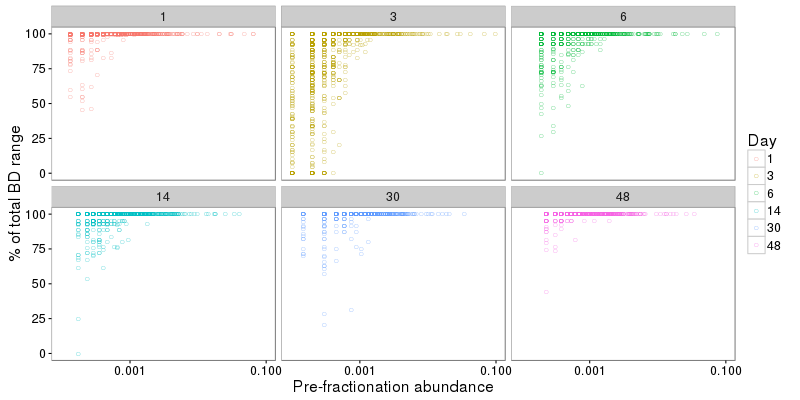

In [29]:
%%R -h 400 -w 800

df.EMP.j.f$Day = reorder(df.EMP.j.f$Day, df.EMP.j.f$Day %>% as.numeric)

## plotting
ggplot(df.EMP.j.f, aes(mean_preFrac_abund, BD_range_perc, color=Day)) +
    geom_point(alpha=0.5, shape='O') +
    scale_x_log10() +
    scale_y_continuous() +
    facet_wrap(~ Day) +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank()#,
        #legend.position = 'none'
        )


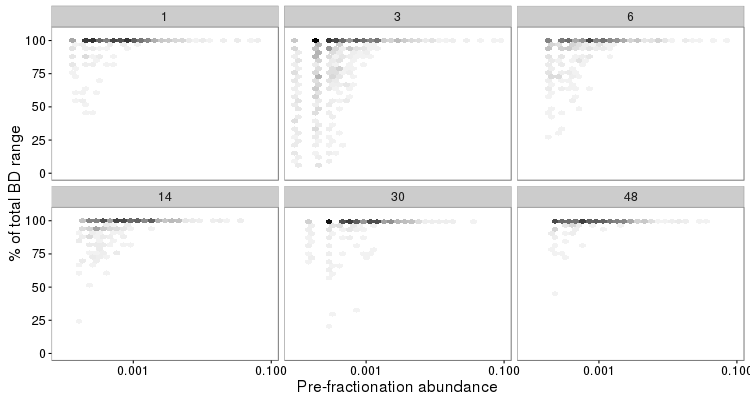

In [55]:
%%R -h 400 -w 750

df.EMP.j.f$Day = reorder(df.EMP.j.f$Day, df.EMP.j.f$Day %>% as.numeric)

## plotting
p.span.hex = ggplot(df.EMP.j.f, aes(mean_preFrac_abund, BD_range_perc)) +
    geom_hex() +
    scale_x_log10() +
    scale_y_continuous(limits=c(0,105)) +
    scale_fill_gradient(low='grey95', high='black') +
    facet_wrap(~ Day, ncol=3) +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank(),
        legend.position = 'none'
        )
p.span.hex

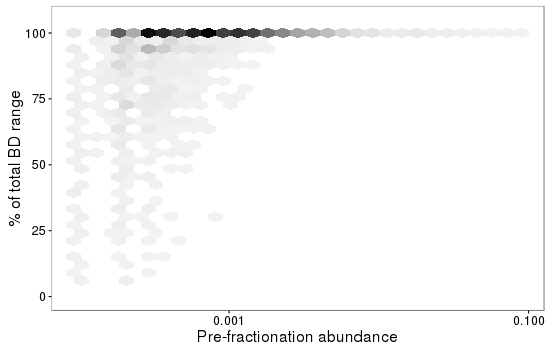

In [32]:
%%R -h 350 -w 550
## plotting
ggplot(df.EMP.j.f, aes(mean_preFrac_abund, BD_range_perc)) +
    geom_hex() +
    scale_x_log10() +
    scale_y_continuous(limits=c(0,105)) +
    scale_fill_gradient(low='grey95', high='black') +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank(),
        legend.position = 'none'
        )

# Assessing diversity

### Asigning zeros 

In [33]:
%%R
# giving value to missing abundances
min.pos.val = df.EMP %>%
    filter(abundance > 0) %>%
    group_by() %>%
    mutate(min_abund = min(abundance)) %>%
    ungroup() %>%
    filter(abundance == min_abund)

min.pos.val = min.pos.val[1,'abundance'] %>% as.numeric
imp.val = min.pos.val / 10


# convert numbers
#df.EMP[df.EMP$abundance == 0, 'abundance'] = imp.val

# another closure operation
df.EMP = df.EMP %>%
    group_by(sample) %>%
    mutate(abundance = abundance / sum(abundance),
           Day = Day %>% as.character)

df.EMP$Day = reorder(df.EMP$Day, df.EMP$Day %>% as.numeric)

# status
cat('Below detection level abundances converted to: ', imp.val, '\n')

Below detection level abundances converted to:  4.037957e-06 


## Shannon diversity

In [34]:
%%R
# shannon index
shannon_index_long = function(df, abundance_col, ...){
    # calculating shannon diversity index from a 'long' formated table
    ## community_col = name of column defining communities
    ## abundance_col = name of column defining taxon abundances
    ## ... = group_by columns
    df = df %>% as.data.frame
    cmd = paste0(abundance_col, '/sum(', abundance_col, ')')
    df.s = df %>%
        group_by_(...) %>%
        mutate_(REL_abundance = cmd) %>%
        mutate(pi__ln_pi = REL_abundance * log(REL_abundance),
               shannon = -sum(pi__ln_pi, na.rm=TRUE)) %>%
        ungroup() %>% 
        dplyr::select(-REL_abundance, -pi__ln_pi) %>%
        distinct_(...) 
    return(df.s)
}

In [35]:
%%R
# calulcating 
df.EMP.shan = shannon_index_long(df.EMP, 'abundance', 'sample') %>%
    filter(Buoyant_density >= min_BD, 
           Buoyant_density <= max_BD)
df.EMP.shan %>% head(n=3) %>% as.data.frame

       OTU            sample    abundance primer_number fwd_barcode rev_barcode
1 OTU.1130 12C-Con.D3.R3_F20 0.0000000000            86    CGTGAGTG    GTCTATGA
2 OTU.1130 12C-Con.D3.R3_F18 0.0008324084            84    CTGCGTGT    GTCTATGA
3 OTU.1130 12C-Con.D3.R3_F11 0.0000000000            77    TCATCGAG    GTCTGCTA
  Substrate Day Microcosm_replicate Fraction Buoyant_density Sample_type
1   12C-Con   3                   3       20        1.701269     unknown
2   12C-Con   3                   3       18        1.710011     unknown
3   12C-Con   3                   3       11        1.737330     unknown
         library Exp_type Sample_location Sample_date Sample_treatment
1 150727_V4_Lib5      SIP              NA          NA               NA
2 150727_V4_Lib5      SIP              NA          NA               NA
3 150727_V4_Lib5      SIP              NA          NA               NA
  Sample_subtreatment core_dataset  shannon
1                  NA         TRUE 5.209807
2               

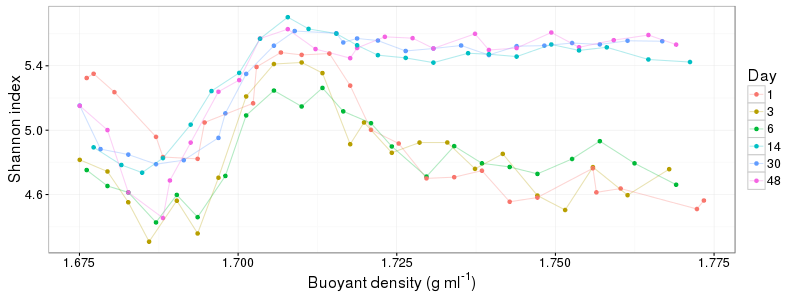

In [39]:
%%R -w 800 -h 300

x.lab = expression(paste('Buoyant density (g ml' ^ '-1', ')'))

# plotting
p.shan = ggplot(df.EMP.shan, aes(Buoyant_density, shannon, color=Day, group=Day)) +
    geom_point() +
    geom_line(alpha=0.3) +
    labs(x=x.lab, y='Shannon index') +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    )
p.shan

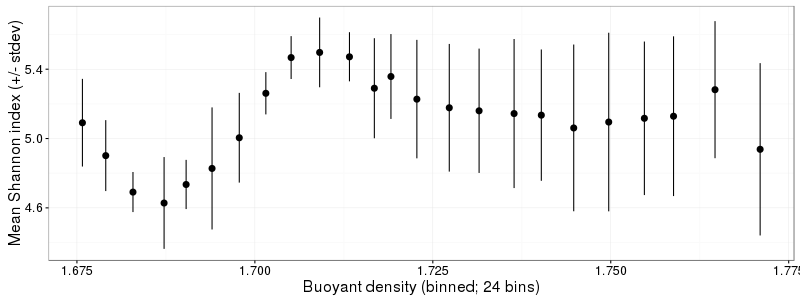

In [40]:
%%R -w 800 -h 300

# summary plot
df.EMP.shan.s = df.EMP.shan %>%
    group_by(BD_bin = ntile(Buoyant_density, 24)) %>%
    summarize(mean_BD = mean(Buoyant_density), 
              mean_shannon = mean(shannon),
              sd_shannon = sd(shannon))

# plotting
p = ggplot(df.EMP.shan.s, aes(mean_BD, mean_shannon,
                              ymin=mean_shannon-sd_shannon, 
                              ymax=mean_shannon+sd_shannon)) +
    geom_pointrange() +
    labs(x='Buoyant density (binned; 24 bins)', y='Mean Shannon index (+/- stdev)') +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    )
p

# Plotting variance


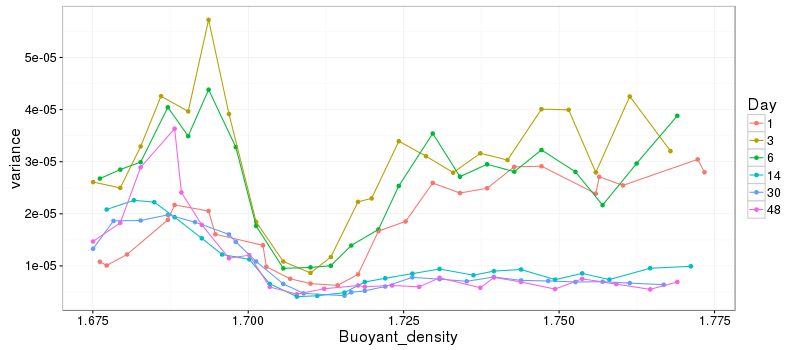

In [41]:
%%R -w 800 -h 350
df.EMP.var = df.EMP %>%
    group_by(Day, sample) %>%
    mutate(variance = var(abundance)) %>%
    ungroup() %>%
    distinct(Day, sample) %>%
    select(Day, sample, variance, Buoyant_density)

ggplot(df.EMP.var, aes(Buoyant_density, variance, color=Day)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

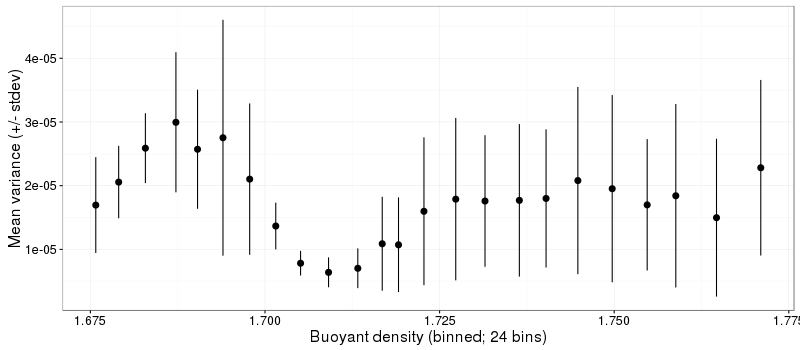

In [42]:
%%R -w 800 -h 350
df.EMP.var.s = df.EMP.var %>%
    group_by(BD_bin = ntile(Buoyant_density, 24)) %>%
    summarize(mean_BD = mean(Buoyant_density),
              mean_var = mean(variance),
              sd_var = sd(variance))

ggplot(df.EMP.var.s, aes(mean_BD, mean_var,
                        ymin=mean_var-sd_var,
                        ymax=mean_var+sd_var)) +
    geom_pointrange() +
    labs(x='Buoyant density (binned; 24 bins)', y='Mean variance (+/- stdev)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Correlograms

### delta BDs

In [43]:
%%R
BD.diffs = function(BDs){
    df.BD = expand.grid(BDs, BDs)
    df.BD$diff = df.BD %>% apply(1, diff) %>% abs %>% as.vector    
    df.BD = df.BD %>%
        spread(Var1, diff) 
    rownames(df.BD) = df.BD$Var2
    df.BD$Var2 = NULL
    dist.BD = df.BD %>% as.matrix
    dist.BD[upper.tri(dist.BD, diag=TRUE)] = 0
    dist.BD %>% as.dist
    }


days = df.EMP$Day %>% unique
BDs.l = list()
for(d in days){
    tmp = df.EMP %>% filter(Day == d) 
    BDs.l[[d]] = tmp$Buoyant_density %>% unique
}

BD.dist.l = lapply(BDs.l, BD.diffs)
BD.dist.l %>% names

[1] "3"  "6"  "30" "1"  "48" "14"


### Bray-curtis ~ BD_diff

In [44]:
%%R

vegdist.by = function(day, df.EMP, ...){
    df.EMP.w = df.EMP %>%
        filter(Day == day) %>%
        select(OTU, sample, abundance) %>%
        spread(OTU, abundance) %>%
        as.data.frame()
    
    rownames(df.EMP.w) = df.EMP.w$sample
    df.EMP.w$sample = NULL
    
    vegan::vegdist(df.EMP.w, ...)
}


days = df.EMP$Day %>% unique %>% sort

bray.l = list()
for (d in days){
    bray.l[[d]] = vegdist.by(d, df.EMP, method='bray')    
}
bray.l %>% names

[1] "1"  "3"  "6"  "14" "30" "48"


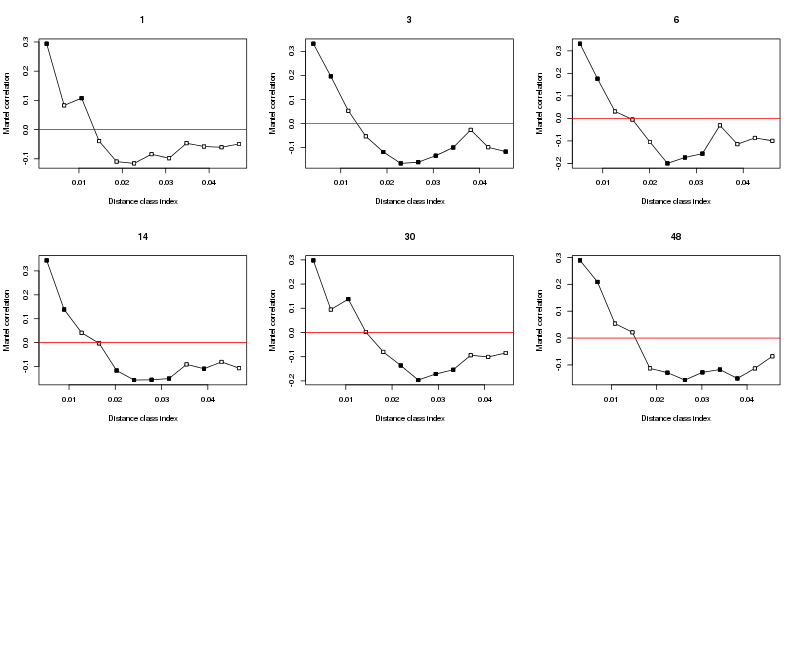

In [45]:
%%R -w 800 -h 650

cal.corr = function(d, BDs, nclass=24, ...){
    #d = vegdist(df, ...)
    d[is.nan(d)] = 0
    stopifnot((d %>% length) == (BDs %>% length))
    
    mantel.correlog(d, BDs, n.class=nclass)
}

days = df.EMP$Day %>% unique %>% sort
corr.l = list()
for(d in days){
    corr.l[[d]] = cal.corr(bray.l[[d]], BD.dist.l[[d]])
}

par(mfrow=c(3,3))
for (n in names(corr.l)){
    plot(corr.l[[n]])
    title(n)
}

In [46]:
%%R
# making df of mantel values
corr.l.mantel = list()
for (n in corr.l %>% names){
    corr.l.mantel[[n]] = corr.l[[n]]['mantel.res'][[1]] %>% as.data.frame
    corr.l.mantel[[n]]$Day = n
    colnames(corr.l.mantel[[n]]) = c('class.index', 'n.dist', 'Mantel.corr', 'Pr', 'Pr.corr', 'Day')
}
df.corr = do.call(rbind, corr.l.mantel) %>% as.data.frame
df.corr %>% head

         class.index n.dist Mantel.corr    Pr Pr.corr Day
1.D.cl.1 0.002561156     44  0.29395823 0.001   0.001   1
1.D.cl.2 0.006590709     28  0.08282747 0.108   0.108   1
1.D.cl.3 0.010620261     42  0.10761009 0.019   0.038   1
1.D.cl.4 0.014649814     52 -0.03945088 0.203   0.216   1
1.D.cl.5 0.018679366     38 -0.10945803 0.024   0.076   1
1.D.cl.6 0.022708919     36 -0.11564685 0.015   0.075   1


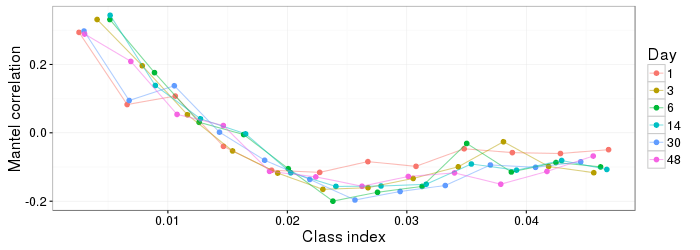

In [49]:
%%R -w 700 -h 250

df.corr.e = df.corr %>%
    filter(! is.na(Mantel.corr)) #%>%
#    mutate(Pr.corr = ifelse(is.na(Pr.corr), 1, Pr.corr) %>% as.numeric,
#           Pr.corr.bool = ifelse(Pr.corr < 0.05, '<0.05', '>0.05'))

df.corr.e$Day = reorder(df.corr.e$Day, df.corr.e$Day %>% as.numeric)

p.corr = ggplot(df.corr.e, aes(class.index, Mantel.corr, color=Day)) +
    geom_point(size=2) +
    geom_line(alpha=0.5) +
    labs(x='Class index', y='Mantel correlation') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.corr

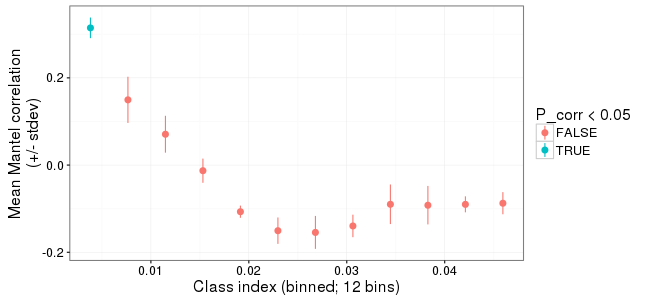

In [48]:
%%R -w 650 -h 300
# summarizing
df.corr.s = df.corr %>%
    filter(! is.na(Mantel.corr)) %>%
    group_by(bin = ntile(class.index, 12)) %>%
    summarize(n = n(),
              mean.class.index = mean(class.index),
              mean.Mantel.corr = mean(Mantel.corr, na.rm=TRUE),
              sd.Mantel.corr = sd(Mantel.corr, na.rm=TRUE),
              max.Pr.corr = max(Pr.corr, na.rm=TRUE)) %>%
    ungroup() %>%
    mutate(significant = ifelse(max.Pr.corr <= 0.05, TRUE, FALSE))


# plotting
ggplot(df.corr.s, aes(mean.class.index, mean.Mantel.corr, color=significant,
                      ymin=mean.Mantel.corr-sd.Mantel.corr,
                      ymax=mean.Mantel.corr+sd.Mantel.corr)) +
    geom_pointrange() +
    scale_color_discrete('P_corr < 0.05') +
    labs(x='Class index (binned; 12 bins)', y='Mean Mantel correlation\n(+/- stdev)') +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    ) 

# DNA conc. of each fraction

* picoGreen measurements of DNA conc. in each fraction
* For MS figure

## Loading data

In [83]:
%%R
SIPdbFile = '/home/nick/db/SIPdb/DOE_SIP_db.xlsx'
workDir = '/var/seq_data/fullCyc/SIP_pipeline_PCR/gradient_pico/'
approx_elute_volume = 45   # ul

In [84]:
%%R 
# loading tables from SIPdb

tbl.fracs = gdata::read.xls(SIPdbFile, sheet='Fractions', header=TRUE)
tbl.fracs.pico = gdata::read.xls(SIPdbFile, sheet='Fractions_pico', header=TRUE)

## Filtering/editing

In [138]:
%%R
tbl.fracs = tbl.fracs %>% 
    filter(experiment == 'fullCyc') %>% 
    group_by(sample_id) %>%
    top_n(1, gradient_date) 

tbl.fracs.pico = tbl.fracs.pico %>%
    filter(experiment == 'fullCyc') 

tbl.fracs.pico$adjConc[tbl.fracs.pico$adjConc < 0] = 0


# joining tables
tbl.fp = inner_join(tbl.fracs, tbl.fracs.pico, c('sample_id' = 'gradient_sample', 
                                                'gradient_date' = 'gradient_date',
                                                'fraction_id' = 'sample'))

# filtering
samps = c("12C-Con.D3.R3", "12C-Con.D6.R2", "12C-Con.D30.R1",
          "12C-Con.D1.R2", "12C-Con.D48.R3", "12C-Con.D14.R1")
tbl.fp = tbl.fp %>%
    filter(sample_id %in% samps) %>%
    mutate(Day = gsub('.+D([0-9]+).R.+', '\\1', sample_id))

# normalizing values to max 
tbl.fp = tbl.fp %>%
    group_by(sample_id) %>%
    mutate(adjConc  = adjConc / max(adjConc, na.rm=TRUE)) %>%
    ungroup() 

# reorder
tbl.fp$Day = reorder(tbl.fp$Day, tbl.fp$Day %>% as.numeric)

tbl.fp %>% .$sample_id %>% unique %>% print
tbl.fp %>% head(n=3)

[1] "12C-Con.D48.R3" "12C-Con.D30.R1" "12C-Con.D1.R2"  "12C-Con.D3.R3" 
[5] "12C-Con.D6.R2"  "12C-Con.D14.R1"
Source: local data frame [3 x 31]

       sample_id gradient_date fractionation_date fraction_id well_id     RI
           (chr)        (fctr)             (fctr)       (int)  (fctr)  (dbl)
1 12C-Con.D48.R3    2015-03-20         2015-03-23           1     H12 1.4093
2 12C-Con.D48.R3    2015-03-20         2015-03-23           1     H12 1.4093
3 12C-Con.D48.R3    2015-03-20         2015-03-23           2     G12 1.4090
Variables not shown: RI_corrected (dbl), BD (dbl), volume (lgl), experiment.x
  (fctr), X (lgl), X.1 (lgl), X.2 (lgl), X.3 (lgl), X.4 (lgl), X.5 (lgl), X.6
  (lgl), X.7 (lgl), X.8 (lgl), X.9 (lgl), pico_run_date (fctr), wells (fctr),
  RFU_Values (fctr), concentration (fctr), mean_conc (dbl), SD (dbl), CV (dbl),
  dilution (int), adjConc (dbl), experiment.y (fctr), Day (fctr)


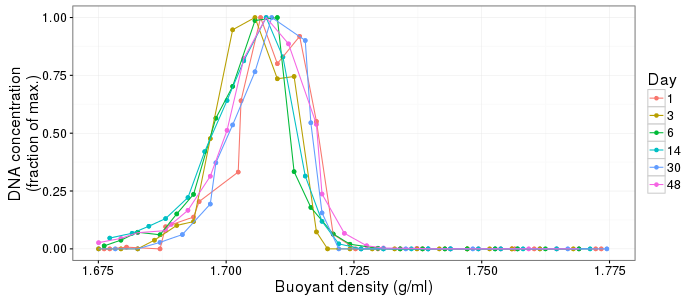

In [154]:
%%R -w 700 -h 300
# plotting
p.pico = ggplot(tbl.fp, aes(BD, adjConc, group=Day, color=Day)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(limits=c(1.675, 1.775)) +
    theme_bw() +
    labs(x='Buoyant density (g/ml)', y='DNA concentration\n(fraction of max.)') +
    theme(
        text = element_text(size=16)
    )
p.pico

## Combined plot

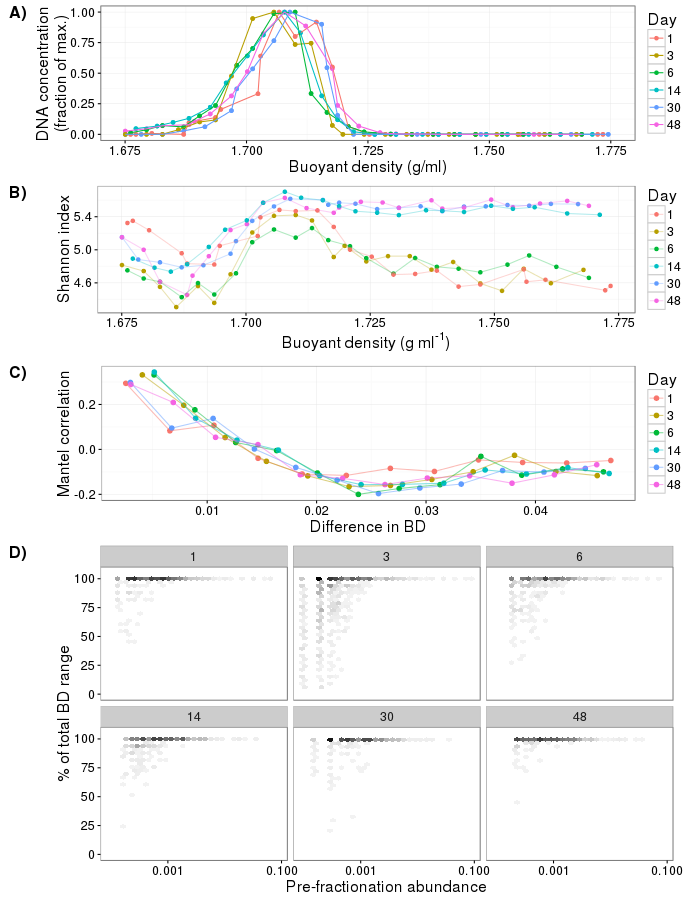

In [155]:
%%R -w 700 -h 900

p.corr.e = p.corr + 
    labs(x='Difference in BD')

p.comb = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), fill='white') +
    cowplot::draw_plot(p.pico, 0.04, 0.80, 0.96, 0.20) +
    cowplot::draw_plot(p.shan, 0.07, 0.60, 0.93, 0.20) +
    cowplot::draw_plot(p.corr.e, 0.07, 0.40, 0.93, 0.20) +
    cowplot::draw_plot(p.span.hex, 0.07, 0.0, 0.90, 0.40) +
    cowplot::draw_plot_label(c('A)', 'B)', 'C)', 'D)'), c(0, 0, 0, 0), c(1, 0.8, 0.6, 0.4))
p.comb

In [156]:
%%R -i workDir
# saving plot
F = file.path(workDir, 'emp-data_summary.pdf') 
ggsave(F, p.comb, width=9.5, height=12)
cat('File written:', F, '\n')

File written: /home/nick/notebook/SIPSim/dev/fullCyc_trim//emp-data_summary.pdf 


### Binary ~ BD_diff

In [116]:
%%R
binary.l = list()
for (d in days){
    binary.l[[d]] = vegdist.by(d, df.EMP, binary=TRUE)    
}
binary.l %>% names

[1] "1"  "3"  "6"  "14" "30" "48"


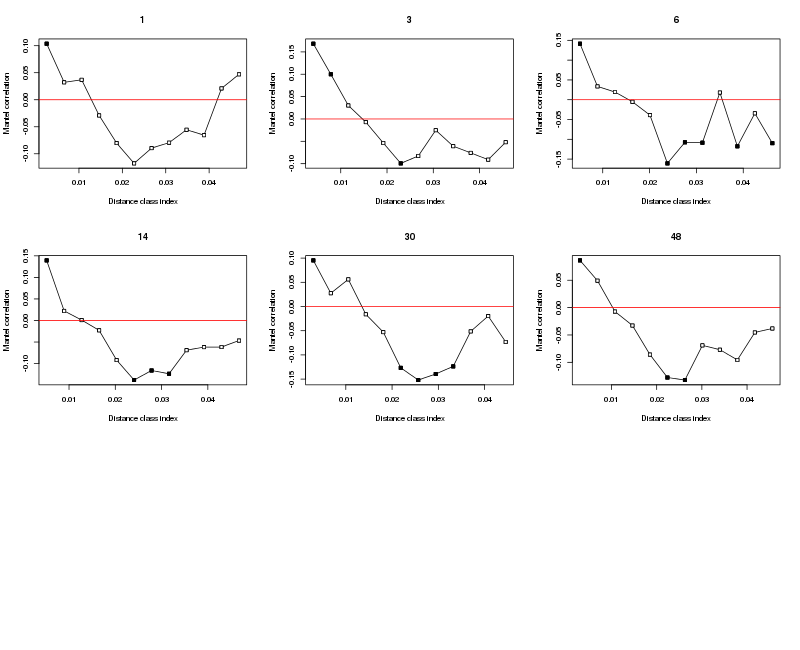

In [117]:
%%R -w 800 -h 650

days = df.EMP$Day %>% unique %>% sort
corr.l = list()
for(d in days){
    corr.l[[d]] = cal.corr(binary.l[[d]], BD.dist.l[[d]])
}

par(mfrow=c(3,3))
for (n in names(corr.l)){
    plot(corr.l[[n]])
    title(n)
}

In [118]:
%%R
# making df of mantel values
corr.l.mantel = list()
for (n in corr.l %>% names){
    corr.l.mantel[[n]] = corr.l[[n]]['mantel.res'][[1]] %>% as.data.frame
    corr.l.mantel[[n]]$Day = n
    colnames(corr.l.mantel[[n]]) = c('class.index', 'n.dist', 'Mantel.corr', 'Pr', 'Pr.corr', 'Day')
}
df.corr = do.call(rbind, corr.l.mantel) %>% as.data.frame
df.corr %>% head

         class.index n.dist Mantel.corr    Pr Pr.corr Day
1.D.cl.1 0.002561156     44  0.10364549 0.003   0.003   1
1.D.cl.2 0.006590709     28  0.03222861 0.319   0.319   1
1.D.cl.3 0.010620261     42  0.03690521 0.212   0.424   1
1.D.cl.4 0.014649814     52 -0.02904201 0.227   0.636   1
1.D.cl.5 0.018679366     38 -0.08017387 0.054   0.216   1
1.D.cl.6 0.022708919     36 -0.11775061 0.014   0.070   1


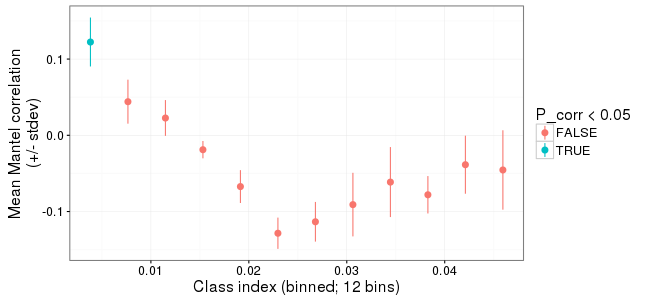

In [119]:
%%R -w 650 -h 300
# summarizing
df.corr.s = df.corr %>%
    filter(! is.na(Mantel.corr)) %>%
    group_by(bin = ntile(class.index, 12)) %>%
    summarize(n = n(),
              mean.class.index = mean(class.index),
              mean.Mantel.corr = mean(Mantel.corr, na.rm=TRUE),
              sd.Mantel.corr = sd(Mantel.corr, na.rm=TRUE),
              max.Pr.corr = max(Pr.corr, na.rm=TRUE)) %>%
    ungroup() %>%
    mutate(significant = ifelse(max.Pr.corr <= 0.05, TRUE, FALSE))


# plotting
ggplot(df.corr.s, aes(mean.class.index, mean.Mantel.corr, color=significant,
                      ymin=mean.Mantel.corr-sd.Mantel.corr,
                      ymax=mean.Mantel.corr+sd.Mantel.corr)) +
    geom_pointrange() +
    scale_color_discrete('P_corr < 0.05') +
    labs(x='Class index (binned; 12 bins)', y='Mean Mantel correlation\n(+/- stdev)') +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    ) 

# Plotting rank-abundance of top taxa for each day

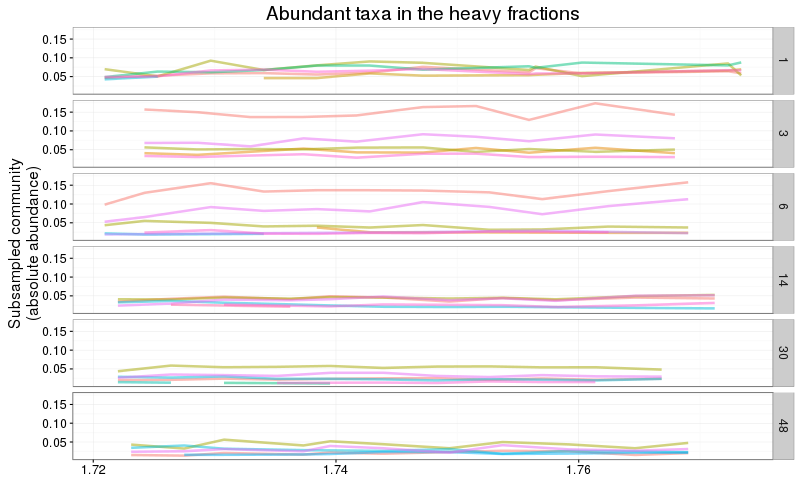

In [161]:
%%R -w 800

df.EMP.f = df.EMP %>%
    filter(Buoyant_density > 1.72) %>%
    group_by(Day, sample) %>%
    mutate(rank = row_number(-abundance)) %>% 
    ungroup() %>%
    filter(rank <= 5) 

ggplot(df.EMP.f, aes(Buoyant_density, abundance, fill=OTU, color=OTU)) +
    geom_line(alpha=0.5, size=1.2) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)', 
         title='Abundant taxa in the heavy fractions') +
    facet_grid(Day ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )

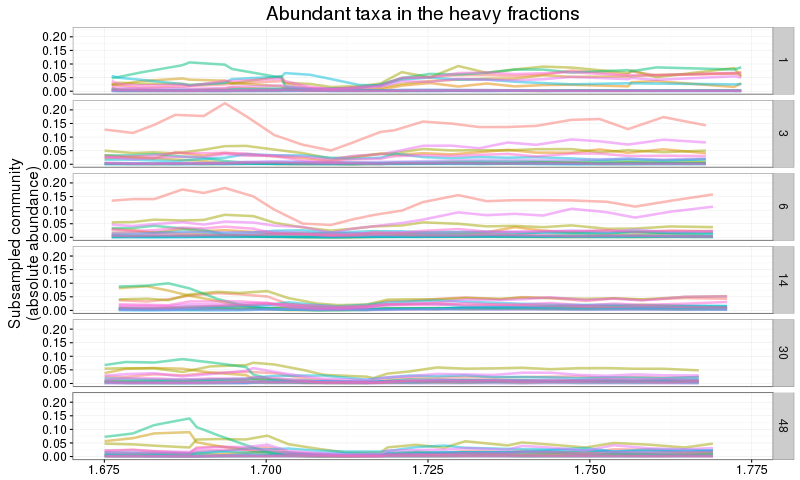

In [162]:
%%R -w 800

df.EMP.f2 = df.EMP %>%
    filter(OTU %in% df.EMP.f$OTU)

ggplot(df.EMP.f2, aes(Buoyant_density, abundance, fill=OTU, color=OTU)) +
    geom_line(alpha=0.5, size=1.2) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)',
                 title='Abundant taxa in the heavy fractions') +
    facet_grid(Day ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )

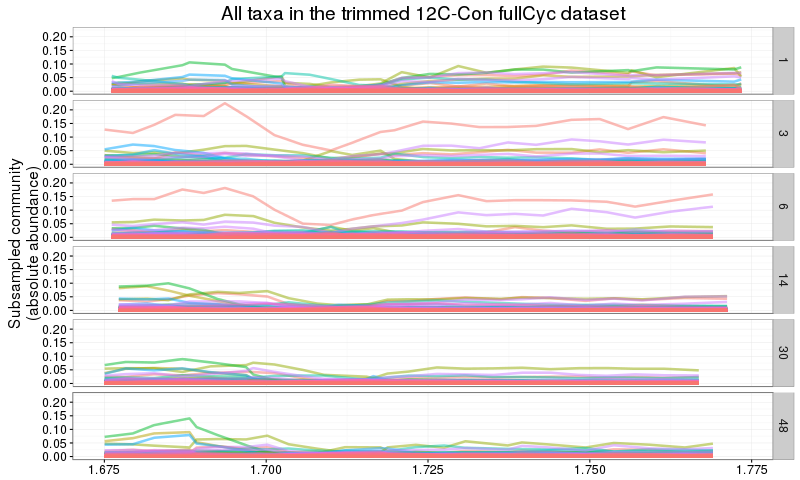

In [163]:
%%R -w 800


ggplot(df.EMP, aes(Buoyant_density, abundance, fill=OTU, color=OTU)) +
    geom_line(alpha=0.5, size=1.2) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)',
                 title='All taxa in the trimmed 12C-Con fullCyc dataset') +
    facet_grid(Day ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )

## Where are these taxa in the pre-fractionation rank-abundance?

In [157]:
%%R

df.EMP.f$OTU %>% unique %>% length %>% print

df.EMP.j %>% 
    group_by(sample) %>%
    mutate(preFrac_rank = row_number(-preFrac_abund)) %>%
    filter(OTU %in% df.EMP.f$OTU) %>%
    distinct(OTU) %>%
    arrange(sample, preFrac_rank) %>%
    select(OTU, sample, preFrac_abund, preFrac_rank) %>% as.data.frame

[1] 15
           OTU             sample preFrac_abund preFrac_rank
1    OTU.14142 12C-Con.D14.R1_F10  0.0401899467            1
2        OTU.1 12C-Con.D14.R1_F10  0.0338197823            2
3        OTU.2 12C-Con.D14.R1_F10  0.0246699097            3
4        OTU.3 12C-Con.D14.R1_F10  0.0178364605            4
5       OTU.67 12C-Con.D14.R1_F10  0.0174310864            5
6     OTU.6870 12C-Con.D14.R1_F10  0.0170836229            6
7    OTU.12920 12C-Con.D14.R1_F10  0.0139564512            7
8        OTU.9 12C-Con.D14.R1_F10  0.0096710679            9
9       OTU.43 12C-Con.D14.R1_F10  0.0086865879           10
10   OTU.10323 12C-Con.D14.R1_F10  0.0074125550           12
11      OTU.16 12C-Con.D14.R1_F10  0.0064280751           13
12      OTU.20 12C-Con.D14.R1_F10  0.0050382210           20
13      OTU.17 12C-Con.D14.R1_F10  0.0049803104           21
14      OTU.35 12C-Con.D14.R1_F10  0.0039958304           35
15       OTU.6 12C-Con.D14.R1_F10  0.0022006023           71
16   OTU.14142 12

## Plotting heavy_fraction_abund ~ pre-fraction_abund

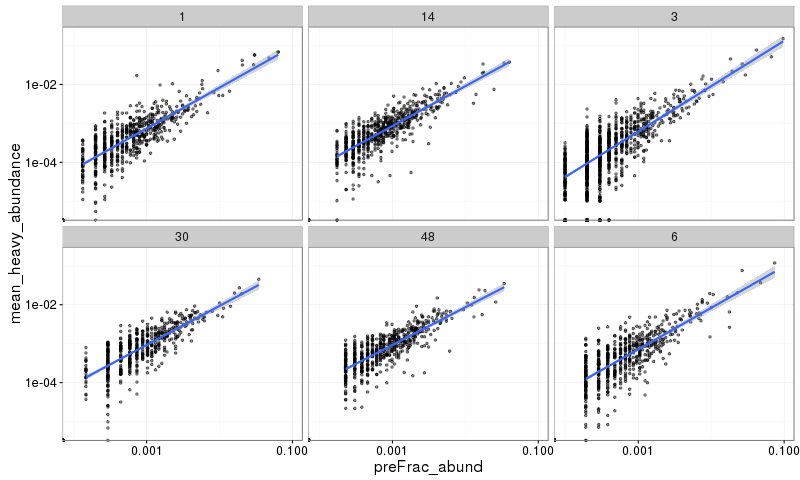

In [171]:
%%R -w 800
df.EMP.j.f = df.EMP.j %>%
    filter(Buoyant_density > 1.72) %>%
    group_by(Day, OTU) %>%
    mutate(mean_heavy_abundance = mean(abundance),
              sd_abundance = sd(abundance)) %>%
    distinct(Day, OTU)
              
F = function(x) x

ggplot(df.EMP.j.f, aes(preFrac_abund, mean_heavy_abundance)) +
    geom_point(alpha=0.5, size=1) +
    geom_smooth(method='lm') +
    scale_x_log10() +
    scale_y_log10() +
    facet_wrap(~ Day) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Plotting light_fraction_abund ~ pre-fraction_abund

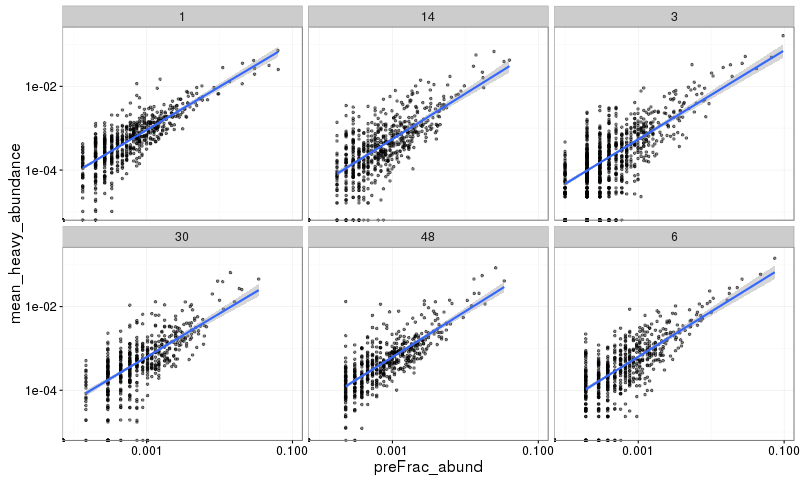

In [173]:
%%R -w 800
df.EMP.j.f = df.EMP.j %>%
    filter(Buoyant_density < 1.695) %>%
    group_by(Day, OTU) %>%
    mutate(mean_heavy_abundance = mean(abundance),
              sd_abundance = sd(abundance)) %>%
    distinct(Day, OTU)
              
F = function(x) x

ggplot(df.EMP.j.f, aes(preFrac_abund, mean_heavy_abundance)) +
    geom_point(alpha=0.5, size=1) +
    geom_smooth(method='lm') +
    scale_x_log10() +
    scale_y_log10() +
    facet_wrap(~ Day) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Getting linear curve fits

In [193]:
%%R
df.EMP.j.f.lm = df.EMP.j.f %>%
    group_by(Day) %>%
    nest() %>%
    mutate(model = purrr::map(data, ~lm(mean_heavy_abundance ~ preFrac_abund, data=.))) %>%
    unnest(model %>% purrr::map(broom::tidy)) %>%
    as.data.frame

df.EMP.j.f.lm

   Day          term     estimate    std.error   statistic       p.value
1    3   (Intercept) 4.573623e-04 5.051505e-05   9.0539803  6.163077e-19
2    3 preFrac_abund 4.361332e-01 1.346771e-02  32.3836171 6.368872e-162
3    6   (Intercept) 1.801750e-04 2.998272e-05   6.0092941  2.533853e-09
4    6 preFrac_abund 8.166819e-01 1.261063e-02  64.7613955  0.000000e+00
5   30   (Intercept) 9.742510e-05 5.161995e-05   1.8873536  5.937708e-02
6   30 preFrac_abund 8.941895e-01 1.214807e-02  73.6075171  0.000000e+00
7    1   (Intercept) 1.894132e-05 1.999332e-05   0.9473825  3.436529e-01
8    1 preFrac_abund 1.076994e+00 1.014063e-02 106.2058784  0.000000e+00
9   48   (Intercept) 1.580024e-04 2.993737e-05   5.2777635  1.575936e-07
10  48 preFrac_abund 8.403800e-01 1.447010e-02  58.0770034  0.000000e+00
11  14   (Intercept) 9.906119e-05 3.999698e-05   2.4767166  1.340989e-02
12  14 preFrac_abund 9.438012e-01 1.222941e-02  77.1746834  0.000000e+00


In [195]:
%%R
# mean estimates
df.EMP.j.f.lm %>%
    group_by(term) %>%
    summarize(mean_est = mean(estimate)) %>%
    as.data.frame

           term     mean_est
1   (Intercept) 0.0001684945
2 preFrac_abund 0.8346966563


# Bray-curtis distances among samples

In [77]:
%%R

vegdist.by = function(day, df.EMP, method='bray'){
    df.EMP.w = df.EMP %>%
        filter(Day == day) %>%
        select(OTU, sample, abundance) %>%
        spread(OTU, abundance) %>%
        as.data.frame()
    
    rownames(df.EMP.w) = df.EMP.w$sample
    df.EMP.w$sample = NULL
    
    vegan::vegdist(df.EMP.w, method=method)
}


days = df.EMP$Day %>% unique %>% sort

bray.l = list()
for (d in days){
    bray.l[[d]] = vegdist.by(d, df.EMP)    
}
bray.l %>% names

[1] "1"  "3"  "6"  "14" "30" "48"


In [78]:
%%R
# nmds ordinations
nmds.l = list()
for (day in names(bray.l)){
    nmds.l[[day]] = vegan::metaMDS(bray.l[[day]])
    }

nmds.l %>% names

Run 0 stress 0.06572545 
Run 1 stress 0.06572545 
... procrustes: rmse 1.115466e-05  max resid 2.602308e-05 
*** Solution reached
Run 0 stress 0.07159508 
Run 1 stress 0.07159488 
... New best solution
... procrustes: rmse 0.001126921  max resid 0.003856184 
*** Solution reached
Run 0 stress 0.05902276 
Run 1 stress 0.2312469 
Run 2 stress 0.05902238 
... New best solution
... procrustes: rmse 0.0008098196  max resid 0.003270727 
*** Solution reached
Run 0 stress 0.03849533 
Run 1 stress 0.03650835 
... New best solution
... procrustes: rmse 0.03174993  max resid 0.07817597 
Run 2 stress 0.05750667 
Run 3 stress 0.03732382 
Run 4 stress 0.05751136 
Run 5 stress 0.03732237 
Run 6 stress 0.03877238 
Run 7 stress 0.03687562 
... procrustes: rmse 0.03413315  max resid 0.07768613 
Run 8 stress 0.03877205 
Run 9 stress 0.05750586 
Run 10 stress 0.03444667 
... New best solution
... procrustes: rmse 0.01600071  max resid 0.06057847 
Run 11 stress 0.03701011 
Run 12 stress 0.03650821 
Run 13 s

In [79]:
%%R
# converting to dataframe
df.nmds = do.call(rbind, lapply(nmds.l, function(x) x$points)) %>%
        as.data.frame
df.nmds$sample = rownames(df.nmds)
df.nmds = inner_join(df.nmds, df.EMP %>% select(-OTU, -abundance), c('sample' = 'sample'))
df.nmds %>% head(n=3)

        MDS1        MDS2            sample primer_number fwd_barcode
1 -0.1347471 -0.09607456 12C-Con.D1.R2_F10           121    CTACTATA
2 -0.1347471 -0.09607456 12C-Con.D1.R2_F10           121    CTACTATA
3 -0.1347471 -0.09607456 12C-Con.D1.R2_F10           121    CTACTATA
  rev_barcode Substrate Day Microcosm_replicate Fraction Buoyant_density
1    ACTCACTG   12C-Con   1                   2       10        1.742794
2    ACTCACTG   12C-Con   1                   2       10        1.742794
3    ACTCACTG   12C-Con   1                   2       10        1.742794
  Sample_type        library Exp_type Sample_location Sample_date
1     unknown 150721_V4_Lib4      SIP              NA          NA
2     unknown 150721_V4_Lib4      SIP              NA          NA
3     unknown 150721_V4_Lib4      SIP              NA          NA
  Sample_treatment Sample_subtreatment core_dataset
1               NA                  NA         TRUE
2               NA                  NA         TRUE
3           

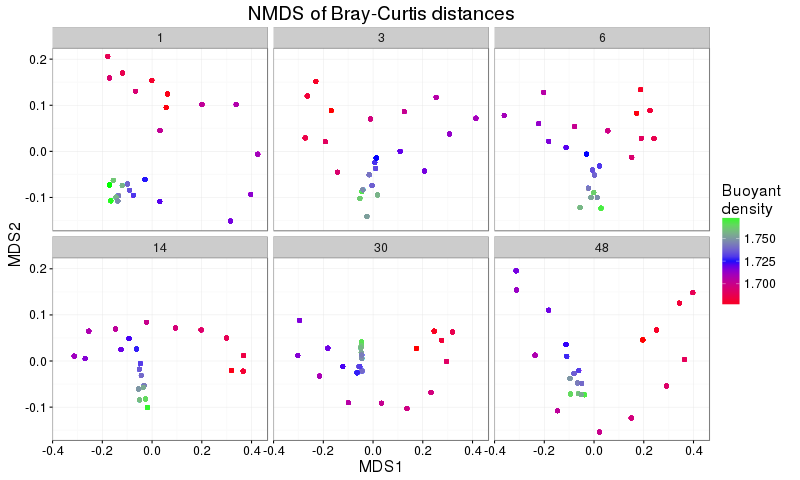

In [80]:
%%R -w 800
# plotting ordinations

ggplot(df.nmds, aes(MDS1, MDS2, color=Buoyant_density)) +
    geom_point() +
    facet_wrap(~ Day) +
    scale_color_gradientn('Buoyant\ndensity', colors=c('red', 'blue', 'green')) +
    labs(title='NMDS of Bray-Curtis distances') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Jaccard distances among samples

In [81]:
%%R
days = df.EMP$Day %>% unique %>% sort

jac.l = list()
for (d in days){
    jac.l[[d]] = vegdist.by(d, df.EMP, method='jaccard')    
}
jac.l %>% names

[1] "1"  "3"  "6"  "14" "30" "48"


In [82]:
%%R
# nmds ordinations
nmds.l = list()
for (day in names(jac.l)){
    nmds.l[[day]] = vegan::metaMDS(jac.l[[day]])
    }

nmds.l %>% names

Run 0 stress 0.06572545 
Run 1 stress 0.06572545 
... procrustes: rmse 4.166673e-06  max resid 1.040331e-05 
*** Solution reached
Run 0 stress 0.07159383 
Run 1 stress 0.07159346 
... New best solution
... procrustes: rmse 0.0003884559  max resid 0.001363925 
*** Solution reached
Run 0 stress 0.05902295 
Run 1 stress 0.06652054 
Run 2 stress 0.06650912 
Run 3 stress 0.06985272 
Run 4 stress 0.05902266 
... New best solution
... procrustes: rmse 0.0009786764  max resid 0.003990112 
*** Solution reached
Run 0 stress 0.03849333 
Run 1 stress 0.03687606 
... New best solution
... procrustes: rmse 0.01563578  max resid 0.05896893 
Run 2 stress 0.05715048 
Run 3 stress 0.03447175 
... New best solution
... procrustes: rmse 0.03223351  max resid 0.08366521 
Run 4 stress 0.05787909 
Run 5 stress 0.0351722 
Run 6 stress 0.05750435 
Run 7 stress 0.03650814 
Run 8 stress 0.03517303 
Run 9 stress 0.05787933 
Run 10 stress 0.03517245 
Run 11 stress 0.03444573 
... New best solution
... procrustes: 

In [83]:
%%R
# converting to dataframe
df.nmds = do.call(rbind, lapply(nmds.l, function(x) x$points)) %>%
        as.data.frame
df.nmds$sample = rownames(df.nmds)
df.nmds = inner_join(df.nmds, df.EMP %>% select(-OTU, -abundance), c('sample' = 'sample'))
df.nmds %>% head(n=3)

        MDS1       MDS2            sample primer_number fwd_barcode rev_barcode
1 -0.1635094 -0.1165862 12C-Con.D1.R2_F10           121    CTACTATA    ACTCACTG
2 -0.1635094 -0.1165862 12C-Con.D1.R2_F10           121    CTACTATA    ACTCACTG
3 -0.1635094 -0.1165862 12C-Con.D1.R2_F10           121    CTACTATA    ACTCACTG
  Substrate Day Microcosm_replicate Fraction Buoyant_density Sample_type
1   12C-Con   1                   2       10        1.742794     unknown
2   12C-Con   1                   2       10        1.742794     unknown
3   12C-Con   1                   2       10        1.742794     unknown
         library Exp_type Sample_location Sample_date Sample_treatment
1 150721_V4_Lib4      SIP              NA          NA               NA
2 150721_V4_Lib4      SIP              NA          NA               NA
3 150721_V4_Lib4      SIP              NA          NA               NA
  Sample_subtreatment core_dataset
1                  NA         TRUE
2                  NA         TRUE

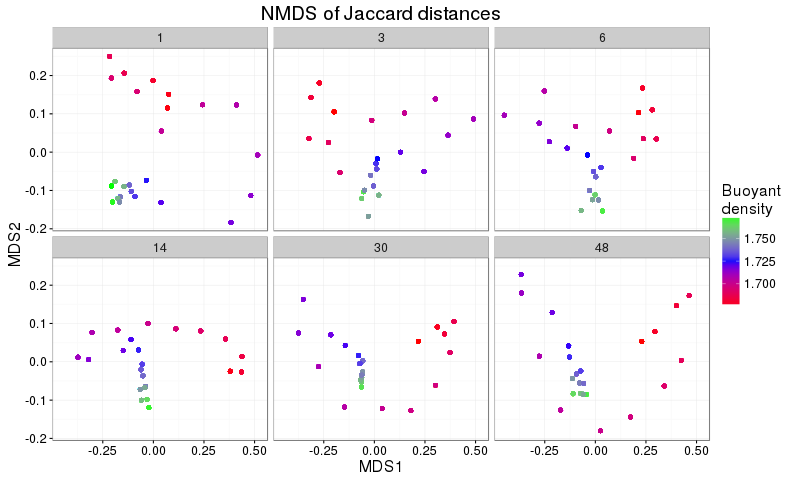

In [84]:
%%R -w 800
# plotting ordinations

ggplot(df.nmds, aes(MDS1, MDS2, color=Buoyant_density)) +
    geom_point() +
    facet_wrap(~ Day) +
    scale_color_gradientn('Buoyant\ndensity', colors=c('red', 'blue', 'green')) +
    labs(title='NMDS of Jaccard distances') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Calculating Aitchison distances among samples

In [62]:
%%R
.aDist = function(x, df){
    i = x[1]
    ii = x[2]
    aDist(df[i,], df[ii,])
}

aDist.all = function(df, meta=NULL){
    # pairwise aDist on all rows
    i.ii = combn(1:nrow(df), m=2)
    #i.ii = combn(1:nrow(df), m=2)[,1:10]
    vals = apply(i.ii, 2, .aDist, df=df)
    
    vals = cbind(i.ii %>% t, vals)
    vals = as.data.frame(vals)
    colnames(vals) = c('V1', 'V2', 'aDist')
    
    
    # adding metadata if provided
    if(! is.null(meta)){
        if(class(meta) != 'data.frame'){
            meta = as.data.frame(meta)
        }
        meta$V1 = 1:nrow(meta)
        
        vals = inner_join(vals, meta, c('V1' = 'V1'))
        vals = inner_join(vals, meta, c('V2' = 'V1'))
    }
    
    # returns a dataframe of values
    return(vals)
}

In [61]:
%%R

days = df.EMP$Day %>% unique %>% as.vector

aDist.l = list()
for (d in days){
    # selecting
    df.p = df.EMP %>% filter(Day == d)
 
    # metadata
    meta = df.p %>%
        select(sample, Buoyant_density) %>%
        distinct(sample) %>%
        as.data.frame
    
    # reformatting table
    df.p = df.p %>% 
        select(OTU, sample, abundance) %>%
        spread(sample, abundance)
    rownames(df.p) = df.p$OTU
    df.p$OTU = NULL
    
    # reorder metadata
    rownames(meta) = meta$sample
    meta = meta[colnames(df.p), ]
    
    # aDist
    aDist.l[[d]] = aDist.all(df.p, meta)
}

aDist.l %>% names

   V1 V2     aDist          sample.x Buoyant_density.x          sample.y
1   1  2  3.706755 12C-Con.D3.R3_F10          1.741701 12C-Con.D3.R3_F11
2   1  3  6.782691 12C-Con.D3.R3_F10          1.741701 12C-Con.D3.R3_F12
3   1  4  9.255369 12C-Con.D3.R3_F10          1.741701 12C-Con.D3.R3_F13
4   1  5  7.811174 12C-Con.D3.R3_F10          1.741701 12C-Con.D3.R3_F14
5   1  6  1.557697 12C-Con.D3.R3_F10          1.741701 12C-Con.D3.R3_F15
6   1  7  4.106065 12C-Con.D3.R3_F10          1.741701 12C-Con.D3.R3_F16
7   1  8 10.674082 12C-Con.D3.R3_F10          1.741701 12C-Con.D3.R3_F17
8   1  9 10.384275 12C-Con.D3.R3_F10          1.741701 12C-Con.D3.R3_F18
9   1 10  8.292826 12C-Con.D3.R3_F10          1.741701 12C-Con.D3.R3_F19
10  1 11  9.195842 12C-Con.D3.R3_F10          1.741701 12C-Con.D3.R3_F20
   Buoyant_density.y
1           1.737330
2           1.732959
3           1.728588
4           1.724217
5           1.719846
6           1.717660
7           1.713289
8           1.710011
9       

In [19]:
%pushnote aDist complete

In [110]:
%%R
# making all pairwise value df
df.tmp = df.EMP %>% 
    select(OTU, sample, Buoyant_density, abundance) 
df.tmp = inner_join(df.tmp, df.tmp, c('OTU' = 'OTU')) 

# calcualting a-dist
df.aDist = df.tmp %>%
    group_by(sample.x, sample.y) %>%
    mutate(aDist = robCompositions::aDist(abundance.x, abundance.y)) %>%
    distinct(sample.x, sample.y)

df.tmp = NULL
df.aDist %>% head

[1] 22119908


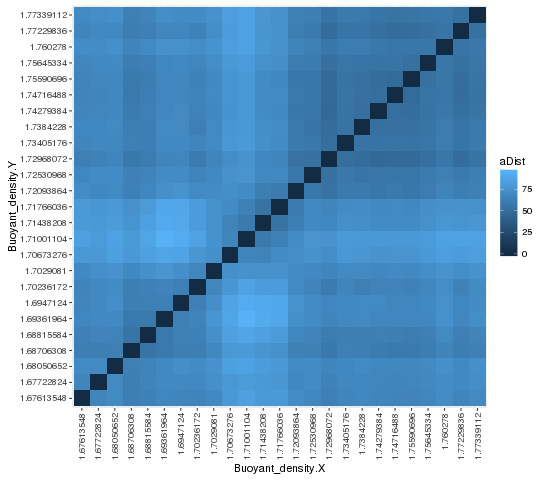

In [179]:
%%R -w 550

df.aDist.e = df.aDist %>%
    mutate(Buoyant_density.X = Buoyant_density.x %>% as.character,
           Buoyant_density.Y = Buoyant_density.y %>% as.character)

df.aDist.e$Buoyant_density.X = reorder(df.aDist.e$Buoyant_density.X, df.aDist.e$Buoyant_density.x)
df.aDist.e$Buoyant_density.Y = reorder(df.aDist.e$Buoyant_density.Y, df.aDist.e$Buoyant_density.y)

ggplot(df.aDist.e, aes(Buoyant_density.X, Buoyant_density.Y, fill=aDist)) +
    geom_tile() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5)
    )

### A-distances as a function of BD distance

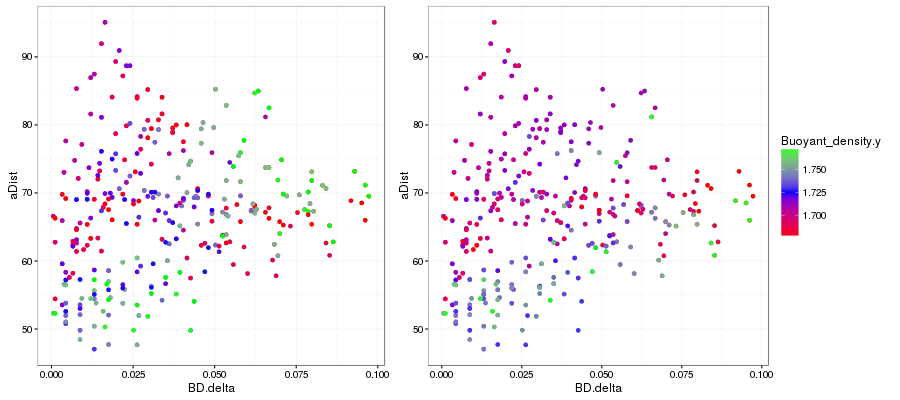

In [161]:
%%R -w 900 -h 400
df.aDist.e = df.aDist %>%
    filter(sample.x != sample.y) %>%
    mutate(BD.delta = abs(Buoyant_density.x - Buoyant_density.y))

p1 = ggplot(df.aDist.e, aes(BD.delta, aDist)) +
    scale_color_gradientn(colors=c('red', 'blue','darkgreen')) +
    theme_bw()
p2 = p1 + geom_point(aes(color=Buoyant_density.y))
p1 = p1 + geom_point(aes(color=Buoyant_density.x)) +
    theme(
        legend.position='none'
    )
    

grid.arrange(p1, p2, ncol=2, widths=c(2.3,3))